## Final Project Submission

Please fill out:
* Student name: John Dean
* Student pace: Part time
* Scheduled project review date/time: 
* Instructor name: Eli Thomas
* Blog post URL:https://www.apogeecoding.com/blog/and-so-it-begins


## Introduction

Microsoft wants to enter the film industry, and is seeking data driven insight into what kinds of films are performing well recently. In this data analysis, we will seek to find the most meaningful business recommendations possible. To this end, we will begin by showing what typical movie budgets might look like and what those budgets tend to bring in terms of return on investment (ROI). We will then look for opportunities for entry by examining the impacts of seasonality, maturity rating, genres, and several combinations of these factors. By the completion of this analysis, our aim is to provide answers for the following core questions:

* What effect does budget have on the success rate of films?
* Does seasonality have an impact on the number or types of films that perform well?
* Does maturity rating have a meaningful impact on the likelihood of success for a film?

## Libraries

We will go ahead an import the necessary libraries and get a preliminary understanding of our data. By the end of this preliminary analysis, we should have an idea of what a typical ROI is on films as well as the size of a normal budget. Our libraries will therefore be focused on computation and visualization.

In [1]:
import pandas as pd # library for data analysis
import numpy as np # advanced computation library
import matplotlib.pyplot as plt # library for plotting data
%matplotlib inline
import seaborn as sns # plotting library we will use for histograms
import os # allows us to interface with computer
import sqlite3 # light weight sql library to handle our large data sets
from glob import glob # file path generation tool
import math

## Data Import, Cleaning, and Prep

For importing and cleaning our data, we will be using a process based heavily on the one found here:

https://github.com/Kaguilar1222/dsc-mod-1-project-v2-1-onl01-dtsc-ft-012120/blob/master/student.ipynb

This process provides a scalable solution for creating a sql table for any number of csv files, rather than hard coding file names or sizes into our code. 

In [2]:
#creating a list of the data we will be reading
files = glob('./zippedData/*.csv.gz')
type(files)

list

In [3]:
#cleaning file name
#creating dictionary of dataframes of each csv and tsv
files_dict = {}
for filename in files:
    if 'csv' in str(os.path.basename(filename)):
        filename_cleaned = os.path.basename(filename).replace(".csv.gz", "").replace(".", "_")
        filename_df = pd.read_csv(filename, compression='gzip', index_col=0)
        files_dict[filename_cleaned] = filename_df

In [4]:
#viewing file names from k:v pairs in our dictionary
files_dict.keys()

dict_keys(['imdb_title_basics', 'imdb_title_ratings', 'tn_movie_budgets'])

In [5]:
#checking a key in the dictionary to ensure that dataframes have been created 
files_dict['tn_movie_budgets'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
release_date         5782 non-null object
movie                5782 non-null object
production_budget    5782 non-null object
domestic_gross       5782 non-null object
worldwide_gross      5782 non-null object
dtypes: object(5)
memory usage: 271.0+ KB


We have some columns in our data that are not in the format we would like them to be in. We will need to format them before passing them to our sql database for queries. 

In [6]:
#converting types of series that are not formatted as we would like
files_dict['imdb_title_basics']['primary_title'] = files_dict['imdb_title_basics']['primary_title'].astype(str) 
files_dict['imdb_title_basics']['original_title'] = files_dict['imdb_title_basics']['original_title'].astype(str)
files_dict['imdb_title_basics']['genres'] = files_dict['imdb_title_basics']['genres'].astype(str) 


In [7]:
# converting the comma separated string of genres into lists
files_dict['imdb_title_basics']['genres'] = files_dict['imdb_title_basics']['genres'].str.split(pat = ',')
files_dict['imdb_title_basics']['genres']

tconst
tt0063540      [Action, Crime, Drama]
tt0066787          [Biography, Drama]
tt0069049                     [Drama]
tt0069204             [Comedy, Drama]
tt0100275    [Comedy, Drama, Fantasy]
                       ...           
tt9916538                     [Drama]
tt9916622               [Documentary]
tt9916706                    [Comedy]
tt9916730                       [nan]
tt9916754               [Documentary]
Name: genres, Length: 146144, dtype: object

In [8]:
# making sure the release dates are datetime dtype
files_dict['tn_movie_budgets']['release_date'] = pd.to_datetime(files_dict['tn_movie_budgets']['release_date'])
files_dict['tn_movie_budgets']['release_date']

id
1    2009-12-18
2    2011-05-20
3    2019-06-07
4    2015-05-01
5    2017-12-15
        ...    
78   2018-12-31
79   1999-04-02
80   2005-07-13
81   2015-09-29
82   2005-08-05
Name: release_date, Length: 5782, dtype: datetime64[ns]

In [9]:
# scrubbing extra characters and converting to int
files_dict['tn_movie_budgets']['production_budget'] = files_dict['tn_movie_budgets']['production_budget'].astype(str)
files_dict['tn_movie_budgets']['production_budget'] = files_dict['tn_movie_budgets']['production_budget'].str.replace('$', '')
files_dict['tn_movie_budgets']['production_budget'] = files_dict['tn_movie_budgets']['production_budget'].str.replace(',', '')
files_dict['tn_movie_budgets']['production_budget'] = pd.to_numeric(files_dict['tn_movie_budgets']['production_budget'])
files_dict['tn_movie_budgets']['domestic_gross'] = files_dict['tn_movie_budgets']['domestic_gross'].astype(str)
files_dict['tn_movie_budgets']['domestic_gross'] = files_dict['tn_movie_budgets']['domestic_gross'].str.replace('$', '')
files_dict['tn_movie_budgets']['domestic_gross'] = files_dict['tn_movie_budgets']['domestic_gross'].str.replace(',', '')
files_dict['tn_movie_budgets']['domestic_gross'] = pd.to_numeric(files_dict['tn_movie_budgets']['domestic_gross'])
files_dict['tn_movie_budgets']['worldwide_gross'] = files_dict['tn_movie_budgets']['worldwide_gross'].astype(str)
files_dict['tn_movie_budgets']['worldwide_gross'] = files_dict['tn_movie_budgets']['worldwide_gross'].str.replace('$', '')
files_dict['tn_movie_budgets']['worldwide_gross'] = files_dict['tn_movie_budgets']['worldwide_gross'].str.replace(',', '')
files_dict['tn_movie_budgets']['worldwide_gross'] = pd.to_numeric(files_dict['tn_movie_budgets']['worldwide_gross'])

## Initial Analysis and Minimum Budgets

Before we can figure out how different factors impact our returns, we need to know what our returns generally will look like overall. For this, we will first find a distribution for budgets across the industry, then we will try to find patterns or trends on those budgets across genres and seasons of release. For the purposes of this analysis, we want to try and maximize our return on investment, so we will ultimately be seeking opportunities to do that.

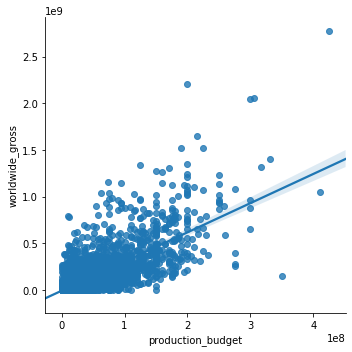

In [10]:
sns.lmplot('production_budget', 'worldwide_gross',
          data = files_dict['tn_movie_budgets'])

Okay, not super useful. We can at least tell that as budgets increase, it seems that so does the gross revenue. Next we're going to try to find out if the rate of success for films increases as the film's production budget increases. In this case, we are going to define a "success" to be a film that makes any amount of positive profit. Films that break even or lose money will not be considered successes.

In [11]:
# Calculating profit of each movie and creating a column to store it
files_dict['tn_movie_budgets']['profit'] = files_dict['tn_movie_budgets']['worldwide_gross'].subtract(files_dict['tn_movie_budgets']['production_budget'])
files_dict['tn_movie_budgets'].head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit
id,,,,,,
1,2009-12-18,Avatar,425000000,760507625,2776345279,2351345279
2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875
3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-200237650
4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963
5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747


In [12]:
# Calculating return on investment and creating a column for that
files_dict['tn_movie_budgets']['roi'] = (files_dict['tn_movie_budgets']['profit']/files_dict['tn_movie_budgets']['production_budget'])*100
files_dict['tn_movie_budgets'].head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,roi
id,,,,,,,
1,2009-12-18,Avatar,425000000,760507625,2776345279,2351345279,553.257713
2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,154.667286
3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-200237650,-57.210757
4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,324.384139
5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,315.369636


In [13]:
# Adding a column to show if a film made movie or not
files_dict['tn_movie_budgets']['success'] = np.where(files_dict['tn_movie_budgets']['profit'] > 0, 'Yes', 'No')
files_dict['tn_movie_budgets'].head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,roi,success
id,,,,,,,,
1,2009-12-18,Avatar,425000000,760507625,2776345279,2351345279,553.257713,Yes
2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,154.667286,Yes
3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-200237650,-57.210757,No
4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,324.384139,Yes
5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,315.369636,Yes


In [14]:
test = [math.floor(len(files_dict['tn_movie_budgets']['production_budget'])/10 * i) for i in range(1,11)]
test

[578, 1156, 1734, 2312, 2891, 3469, 4047, 4625, 5203, 5782]

In [15]:
files_dict['tn_movie_budgets']['production_budget'].iloc[0,]

425000000

In [16]:
catmin = [files_dict['tn_movie_budgets']['production_budget'].iloc[i-1,] for i in test]
catmin

[80000000,
 50000000,
 35000000,
 25000000,
 17000000,
 11000000,
 7000000,
 3500000,
 1100000,
 1100]

In [17]:
files_dict['tn_movie_budgets']['budget_range'] = ['$80,000,000+' if files_dict['tn_movie_budgets']['production_budget'].iloc[i-1,] >= 80000000 
                                                  else '$50,000,000+' if files_dict['tn_movie_budgets']['production_budget'].iloc[i-1,] >= 50000000
                                                  else '$35,000,000+' if files_dict['tn_movie_budgets']['production_budget'].iloc[i-1,] >= 35000000
                                                  else '$25,000,000+' if files_dict['tn_movie_budgets']['production_budget'].iloc[i-1,] >= 25000000
                                                  else '$17,000,000+' if files_dict['tn_movie_budgets']['production_budget'].iloc[i-1,] >= 17000000
                                                  else '$11,000,000+' if files_dict['tn_movie_budgets']['production_budget'].iloc[i-1,] >= 11000000
                                                  else '$7,000,000+' if files_dict['tn_movie_budgets']['production_budget'].iloc[i-1,] >= 7000000
                                                  else '$3,500,000+' if files_dict['tn_movie_budgets']['production_budget'].iloc[i-1,] >= 3500000
                                                  else '$1,100,000+' if files_dict['tn_movie_budgets']['production_budget'].iloc[i-1,] >= 1100000
                                                  else '$1,100+' 
                                                  for i in range(1, len(files_dict['tn_movie_budgets']['production_budget'])+1)]

In [18]:
files_dict['tn_movie_budgets'].head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,roi,success,budget_range
id,,,,,,,,,
1,2009-12-18,Avatar,425000000,760507625,2776345279,2351345279,553.257713,Yes,"$80,000,000+"
2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,154.667286,Yes,"$80,000,000+"
3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-200237650,-57.210757,No,"$80,000,000+"
4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,324.384139,Yes,"$80,000,000+"
5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,315.369636,Yes,"$80,000,000+"


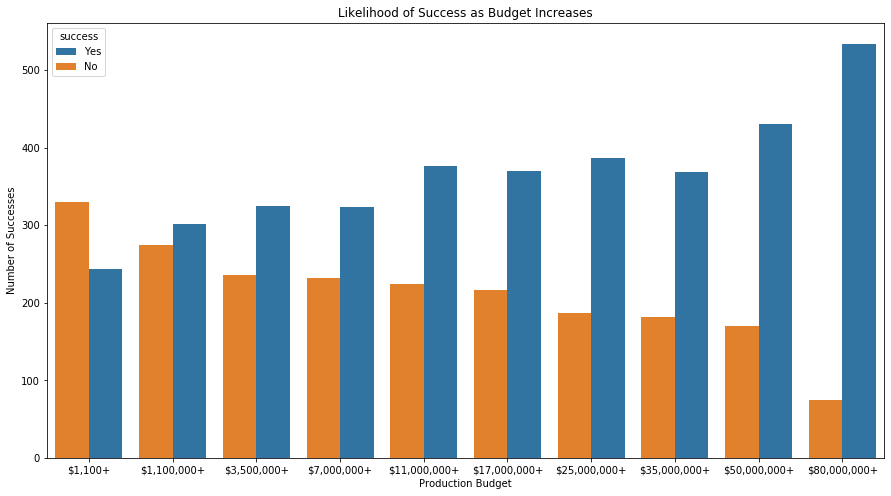

In [19]:
# Creating a visualization to see if budgets influence the likelihood of success for films
plt.figure(figsize = (15, 8))
ax = sns.countplot(x = files_dict['tn_movie_budgets']['budget_range'], 
                 hue = files_dict['tn_movie_budgets']['success'], 
                 data = files_dict['tn_movie_budgets']['success'])
ax.set(xlabel = 'Production Budget', 
       ylabel = 'Number of Successes', 
       title = 'Likelihood of Success as Budget Increases')
ax.invert_xaxis()
plt.show(ax)

As you can see from this chart, there is a very clear point at which movies with a budget of $50,000,000 tend to be far more likely to generate a profit. For this reason, we recommend expecting to spend at least this minimum amount in order to maximize our returns. Moving forward, we will further explore the data from films with only this minimum budget or greater, in order to find out if there are any specific genres or seasonal release times that will further maximize our potential to generate profits.

## Exploring Impact of Genre

In this section, we will first limit our data set to only movies with budgets of $50,000,000 or more, then explore the success rate genre to genre. In order to do this, we will load our tables into a SQLite3 database, then perform the necessary unions and operations to prepare our visualizations.

In [20]:
# Renaming a column to make joining easier later
files_dict['imdb_title_basics'].rename(columns = {'primary_title' : 'movie'}, inplace = True)

In [21]:
files_dict['imdb_title_basics'].head()

,movie,original_title,start_year,runtime_minutes,genres
tconst,,,,,
tt0063540,Sunghursh,Sunghursh,2013,175.0,"[Action, Crime, Drama]"
tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"[Biography, Drama]"
tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,[Drama]
tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"[Comedy, Drama]"
tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"[Comedy, Drama, Fantasy]"


In [22]:
# Joining two dataframes, then dropping extraneous columns and rows
genres_df = files_dict['tn_movie_budgets'].join(files_dict['imdb_title_basics'].set_index('movie'),
                                                on = 'movie', how = 'inner')
genres_df.drop(columns=['domestic_gross', 'worldwide_gross', 'budget_range', 'original_title', 
                'start_year', 'runtime_minutes'], inplace = True)
genres_df = genres_df[genres_df['production_budget'] >= 50000000]
genres_df.head()

,release_date,movie,production_budget,profit,roi,success,genres
id,,,,,,,
1,2009-12-18,Avatar,425000000,2351345279,553.257713,Yes,[Horror]
2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,635063875,154.667286,Yes,"[Action, Adventure, Fantasy]"
3,2019-06-07,Dark Phoenix,350000000,-200237650,-57.210757,No,"[Action, Adventure, Sci-Fi]"
4,2015-05-01,Avengers: Age of Ultron,330600000,1072413963,324.384139,Yes,"[Action, Adventure, Sci-Fi]"
7,2018-04-27,Avengers: Infinity War,300000000,1748134200,582.711400,Yes,"[Action, Adventure, Sci-Fi]"


In [25]:
genres_df = genres_df.reset_index()
genres_df.drop(columns=['id'], inplace=True)

In [27]:
genres_df.head()

,release_date,movie,production_budget,profit,roi,success,genres
0,2009-12-18,Avatar,425000000,2351345279,553.257713,Yes,[Horror]
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,635063875,154.667286,Yes,"[Action, Adventure, Fantasy]"
2,2019-06-07,Dark Phoenix,350000000,-200237650,-57.210757,No,"[Action, Adventure, Sci-Fi]"
3,2015-05-01,Avengers: Age of Ultron,330600000,1072413963,324.384139,Yes,"[Action, Adventure, Sci-Fi]"
4,2018-04-27,Avengers: Infinity War,300000000,1748134200,582.711400,Yes,"[Action, Adventure, Sci-Fi]"


In [28]:
test_df = genres_df['genres'].to_dict()

In [30]:
test_df

{0: ['Horror'],
 1: ['Action', 'Adventure', 'Fantasy'],
 2: ['Action', 'Adventure', 'Sci-Fi'],
 3: ['Action', 'Adventure', 'Sci-Fi'],
 4: ['Action', 'Adventure', 'Sci-Fi'],
 5: ['Action', 'Adventure', 'Fantasy'],
 6: ['Action', 'Adventure', 'Thriller'],
 7: ['Action', 'Thriller'],
 8: ['Action', 'Adventure', 'Fantasy'],
 9: ['Action', 'Adventure', 'Western'],
 10: ['Action', 'Adventure', 'Sci-Fi'],
 11: ['Adventure', 'Animation', 'Comedy'],
 12: ['Action', 'Adventure', 'Sci-Fi'],
 13: ['Action', 'Adventure', 'Fantasy'],
 14: ['Adventure', 'Family', 'Fantasy'],
 15: ['Adventure', 'Fantasy'],
 16: ['Adventure', 'Fantasy'],
 17: ['Action', 'Crime', 'Thriller'],
 18: ['Action', 'Adventure', 'Fantasy'],
 19: ['Action', 'Adventure', 'Sci-Fi'],
 20: ['Action', 'Adventure', 'Sci-Fi'],
 21: ['Action', 'Adventure', 'Sci-Fi'],
 22: ['Action', 'Adventure', 'Sci-Fi'],
 23: ['Action', 'Adventure', 'Sci-Fi'],
 24: ['Action', 'Adventure', 'Sci-Fi'],
 25: ['Action', 'Adventure', 'Sci-Fi'],
 26: ['Actio

In [53]:
new_genre_df = pd.DataFrame(columns = genres_df.columns)
new_genre_df.head()

,release_date,movie,production_budget,profit,roi,success,genres


In [59]:
j = 0
for i in range(0, len(test_df)) :
    genre_list = genres_df['genres'][i]
    if 'NaN' not in genre_list :
        for genre in genre_list :
            new_genre_df = new_genre_df.append(genres_df.iloc[i,])
            new_genre_df['genres'].iloc[j,] = genre
            j +=1
new_genre_df.head(10)

C:\Users\sunfl\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
C:\Users\sunfl\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,release_date,movie,production_budget,profit,roi,success,genres
0,2009-12-18,Avatar,425000000,2351345279,553.257713,Yes,Horror
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,635063875,154.667286,Yes,Action
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,635063875,154.667286,Yes,Adventure
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,635063875,154.667286,Yes,Fantasy
2,2019-06-07,Dark Phoenix,350000000,-200237650,-57.210757,No,Action
2,2019-06-07,Dark Phoenix,350000000,-200237650,-57.210757,No,Adventure
2,2019-06-07,Dark Phoenix,350000000,-200237650,-57.210757,No,Sci-Fi
3,2015-05-01,Avengers: Age of Ultron,330600000,1072413963,324.384139,Yes,Action
3,2015-05-01,Avengers: Age of Ultron,330600000,1072413963,324.384139,Yes,Adventure
3,2015-05-01,Avengers: Age of Ultron,330600000,1072413963,324.384139,Yes,Sci-Fi


In [67]:
new_genre_df.dropna(axis=0, inplace=True)

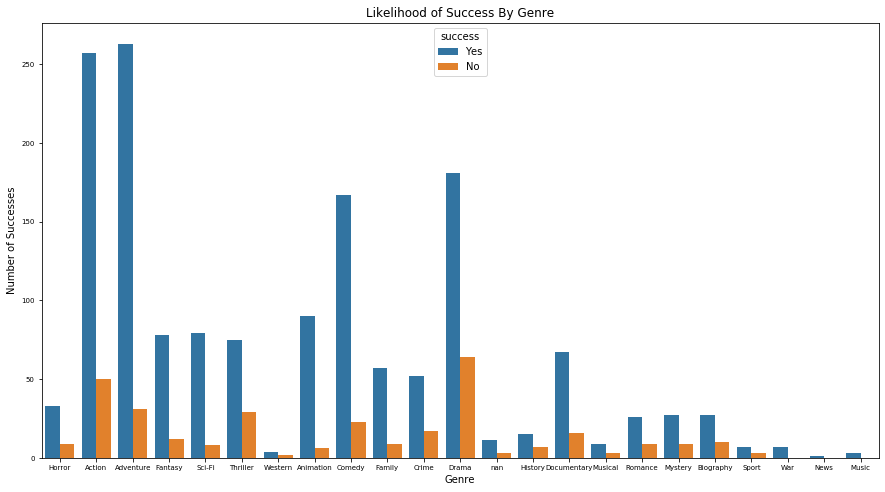

In [76]:
# Creating a visualization to see if genre influences the success of a major budget film
plt.figure(figsize = (15, 8))
ax = sns.countplot(x = new_genre_df['genres'],
                   hue = new_genre_df['success'],
                   data = new_genre_df['success'])
ax.set(xlabel = 'Genre', 
       ylabel = 'Number of Successes', 
       title = 'Likelihood of Success By Genre')
ax.tick_params(labelsize=7)
plt.show(ax)

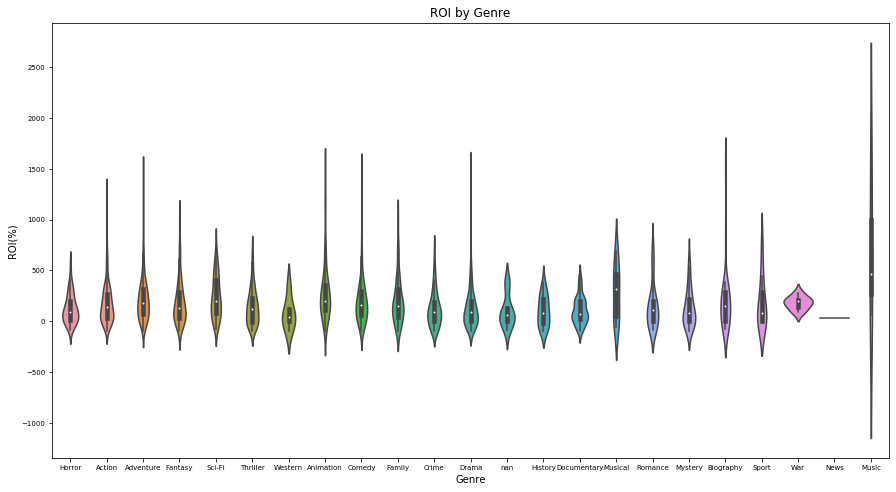

In [82]:
plt.figure(figsize = (15, 8))
ax = sns.violinplot(x = 'genres',
                    y = 'roi',
                    data = new_genre_df)
ax.set(xlabel = 'Genre', 
       ylabel = 'ROI(%)', 
       title = 'ROI by Genre')
ax.tick_params(labelsize=7)
plt.show(ax)

In [22]:
#connecting to new database
conn = sqlite3.connect("movies_db.sqlite")

In [23]:
#creating function to create a SQL table passing a dataframe, name, and 
#connection to database
def create_sql_table_from_df(df, name, conn):
    try:
        df.to_sql(name, conn)
        print(f"Created table {name}")
    except Exception as e:
        print(f"could not make table {name}")
        print(e)

In [24]:
#passing the function through a for loop of the tables and names in our 
#dictionary of csv files
for name, table in files_dict.items():
    create_sql_table_from_df(table, name, conn)

could not make table imdb_title_basics
Error binding parameter 5 - probably unsupported type.
Created table imdb_title_ratings
Created table tn_movie_budgets


In [65]:
#creating a cursor to do a query of our sql db
cur = conn.cursor()

In [66]:
#testing connection on our database of tables
conn.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

[('imdb_title_basics',), ('imdb_title_ratings',), ('tn_movie_budgets',)]